In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from yellowbrick.text import FreqDistVisualizer

In [2]:
input_file = "stack-overflow-data.csv"
df_read = pd.read_csv(input_file)

# Filter the DataFrame df_read to include only rows where the 'tags' column is not null. 
df = df_read[pd.notnull(df_read['tags'])]

# Randomly sample 50% of the rows from the filtered DataFrame df, using a random state of 99 for reproducibility
# We then reset the index of the resulting DataFrame, dropping the old index.
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)

In [3]:
df.head(10)

,post,tags
0,enum explanation needed i have some doubt in ...,objective-c
1,need help calling a function and display messa...,c#
2,append nsinteger to nsmutabledata how do you ...,objective-c
3,code-based transclude inside an each doesn t w...,angularjs
4,how to render a _form from another view folder...,ruby-on-rails
5,calculate salary in exist i have table employ...,sql
6,how do i convert an nsstring of hex numbers (@...,ios
7,sql pivot issues. getting wrong output <pre>tc...,sql
8,mysql gem installation failure in ruby on rail...,ruby-on-rails
9,<% %> in asp.net (embedded code blocks) i und...,asp.net


In [4]:
df.shape

(20000, 2)

## Data Exploration

In [7]:
print(df["post"].apply(lambda x: len(x.split(' '))).sum())

5082744


- we have over 5 million words in the post field

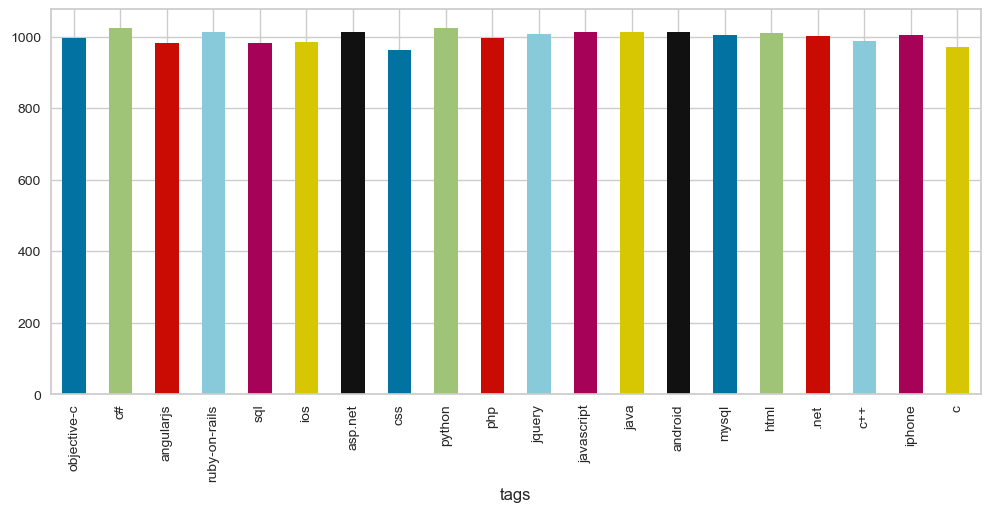

In [8]:
import matplotlib.pyplot as plt

# Get unique tags and assign a color to each tag
unique_tags = df['tags'].unique()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'][:len(unique_tags)]  # You can extend this list for more colors

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Group by 'tags', count posts, and plot with different colors
tag_counts = df.groupby('tags').post.count()
tag_counts.plot.bar(ylim=0, color=colors, ax=ax)

# Set the x-axis labels to the unique tags
ax.set_xticks(range(len(unique_tags)))
ax.set_xticklabels(unique_tags)

plt.show()

The tags are evenly distributed

### Data Analysis

- Checking to see if the label corresponds to the content of the post

In [9]:
def print_plot(index):
    example = df[df.index == index][["post", "tags"]].values[0]
    if len(example) > 0:
        print(example[0])
        print("Tag:", example[1])

In [10]:
print_plot(250)

get session id from another table  i have 3 tables--answers  questions and tokens.    in <code>tokens</code> i have <code>id  token  created_at  updated_at</code>.    in <code>answers</code> i have <code>id  token (id)  text  created_at  updated_at</code>    in <code>questions</code> - <code>id  text</code>    how can i get id (from tokens)   i do this way:   <pre><code>result=answer.create(:question_id=&gt;question.id :token=&gt;session[:token] :text=&gt;params[ answer_ +question.id.to_s]) </code></pre>   i don t want <code>session[:token]</code>  it s pasted in table tokens (for example 23709274092107hdjshdsj) and i    <blockquote>    just need id!  </blockquote>
Tag: ruby-on-rails


In [11]:
print_plot(1001)

when handling file upload with php is the data loaded into memory   when using the ubiquitous file upload paradigm in php  example:   <pre><code>&lt; php if ($_files[ file ][ error ] &gt; 0)   {   echo  error:   . $_files[ file ][ error ] .  &lt;br&gt; ;   } else   {   echo  upload:   . $_files[ file ][ name ] .  &lt;br&gt; ;   echo  type:   . $_files[ file ][ type ] .  &lt;br&gt; ;   echo  size:   . ($_files[ file ][ size ] / 1024) .   kb&lt;br&gt; ;   echo  stored in:   . $_files[ file ][ tmp_name ];   }  &gt; </code></pre>   is the file itself loaded into memory or is the $_files global used as a reference to the file     if the file is not loaded into memory  what is the purpose of this line from the php doc regarding file upload pitfalls:    <strong>if a memory limit is enabled  a larger memory_limit may be needed. make sure you set memory_limit large enough.</strong>    <a href= http://www.php.net/manual/en/features.file-upload.common-pitfalls.php  rel= nofollow >http://www.php.n

### Visualize Token (vocabulary) Frequency Distribution Before Text Preprocessing
- A frequency distribution tells us the frequency of each vocabulary item in the text

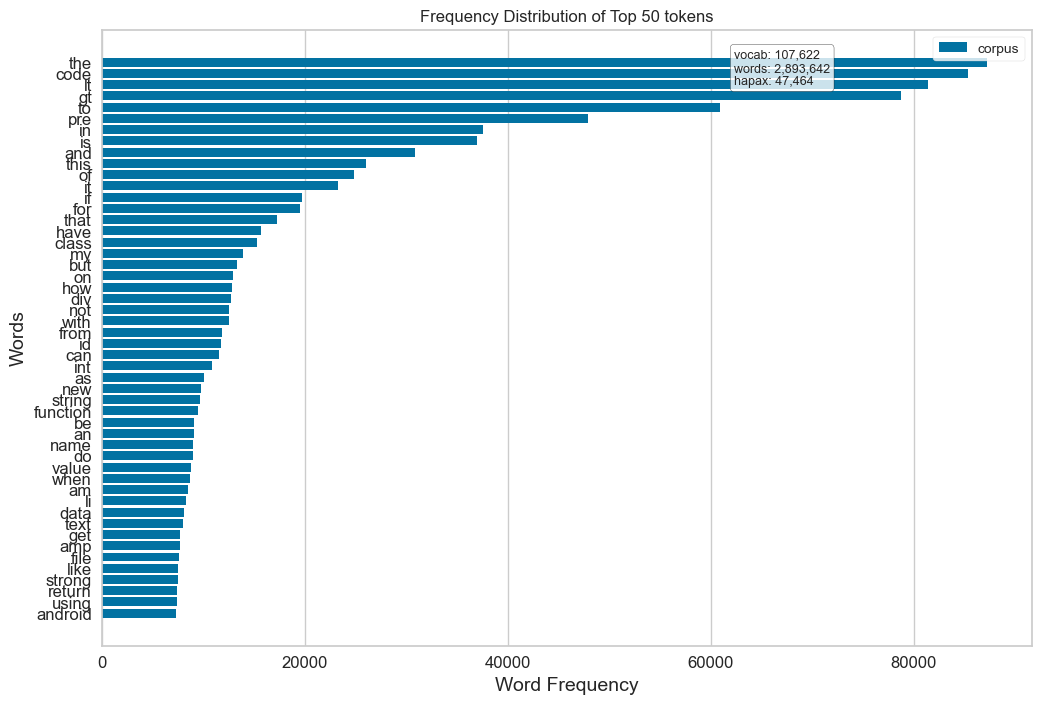

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}, xlabel='Word Frequency', ylabel='Words'>

In [16]:
'''
Using CountVectorizer to convert text data into a "bag of words" representation.

Here's how CountVectorizer works:

Tokenization: First, it tokenizes the text, which means it breaks down the text into individual words or terms. 
It removes punctuation and splits the text into words based on spaces.

Counting: Then, it counts the frequency of each word in the document. Each unique word in the document becomes a feature, 
and the count of that word in the document becomes the value for that feature.

Vectorization: Finally, it represents each document as a vector, where each element in the vector corresponds to the count 
of a specific word in the document. This is often referred to as a "document-term matrix" or "word frequency matrix."
'''

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform your text data
docs = vectorizer.fit_transform(df["post"])
features = vectorizer.get_feature_names_out()

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Create the FreqDistVisualizer object
visualizer = FreqDistVisualizer(features=features)

# Fit the visualizer to the data
visualizer.fit(docs)

# Customize the appearance of the chart
visualizer.ax.set_title("Word Frequency Distribution", fontsize=16)
visualizer.ax.set_xlabel("Word Frequency", fontsize=14)
visualizer.ax.set_ylabel("Words", fontsize=14)
visualizer.color = "skyblue"  # Change the color of the bars
visualizer.alpha = 0.7  # Adjust the transparency of the bars

# Set font size for tick labels
visualizer.ax.tick_params(labelsize=12)

# Show the chart
visualizer.poof()

### Text Preprocessing
For this particular data set, our text cleaning includes the following steps:

- HTML decoding. The BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
- Remove stop words,
- Change text to lower case
- Remove punctuation
-Remove bad characters
and so on.

re.compile(), re.sub(), substitute the matched string with either " " or nothing

In [17]:
# Eliminate specific symbols or characters from the text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# This regex removes symbols and characters that are not alphanumeric or common special characters (specified in BAD_SYMBOLS_RE)
# It essentially removes any characters that are not letters, numbers, spaces, or the characters #, +, and _.
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [18]:
print_plot(250)

get session id another table 3 tablesanswers questions tokens tokens id token created_at updated_at answers id token id text created_at updated_at questions id text get id tokens way resultanswercreate question_idquestionid tokensession token textparams answer_ +questionidto_s want session token pasted table tokens example 23709274092107hdjshdsj need id
Tag: ruby-on-rails


In [19]:
print_plot(1000)

display sql query one table basic sql question wan display output following query one table instead two select playersname players inner join teams playersteam teamsname teamsstaysat ambassador teamscheckin null select fansname fans fansstaysat ambassador teamscheckin null rewrite players name fans name printed one continuous list
Tag: sql


### Visualize Token Frequency Distribution After Text Preprocessing
It is interesting to compare the results of the frequency distribution before and after text preprocessing

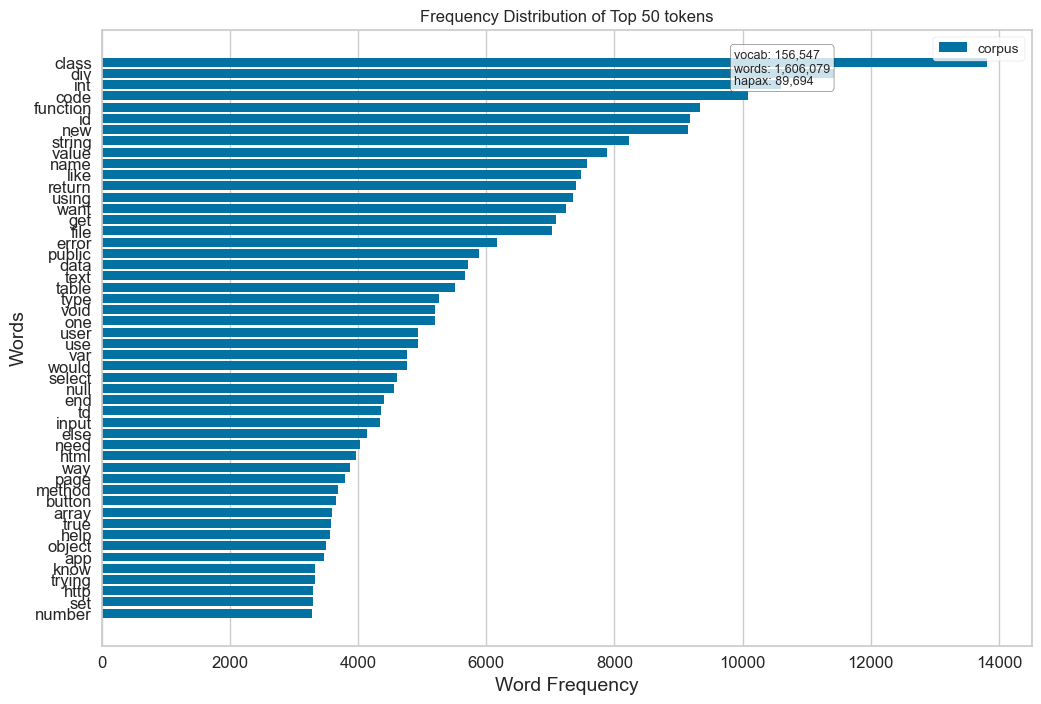

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}, xlabel='Word Frequency', ylabel='Words'>

In [20]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform your text data
docs = vectorizer.fit_transform(df["post"])
features = vectorizer.get_feature_names_out()

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Create the FreqDistVisualizer object
visualizer = FreqDistVisualizer(features=features)

# Fit the visualizer to the data
visualizer.fit(docs)

# Customize the appearance of the chart
visualizer.ax.set_title("Word Frequency Distribution", fontsize=16)
visualizer.ax.set_xlabel("Word Frequency", fontsize=14)
visualizer.ax.set_ylabel("Words", fontsize=14)
visualizer.color = "skyblue"  # Change the color of the bars
visualizer.alpha = 0.7  # Adjust the transparency of the bars

# Set font size for tick labels
visualizer.ax.tick_params(labelsize=12)

# Show the chart
visualizer.poof()

### Visually Compare the Differences in the Frequency Distributions for Two of the Tags: “c++” and “python”.
It is also interesting to explore the differences in tokens across different tags. Let’s visually compare the differences in the frequency distributions for two of the tags: "c++" and "python" 

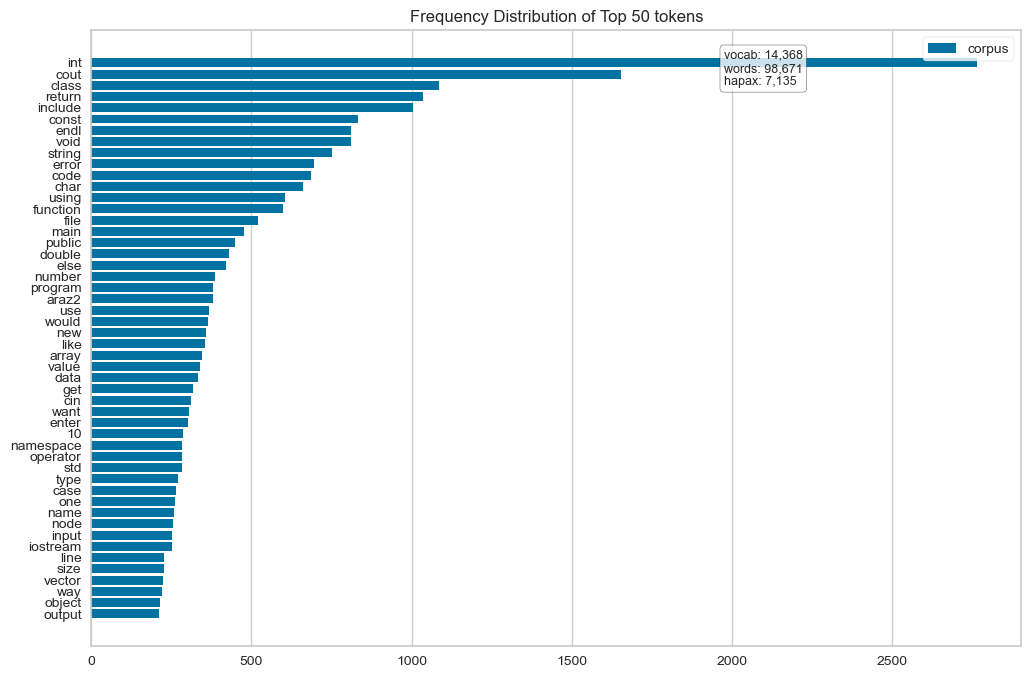

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [23]:
docs       = vectorizer.fit_transform(text for text in df.loc[df['tags'] == 'c++']['post'])
features   = vectorizer.get_feature_names_out()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

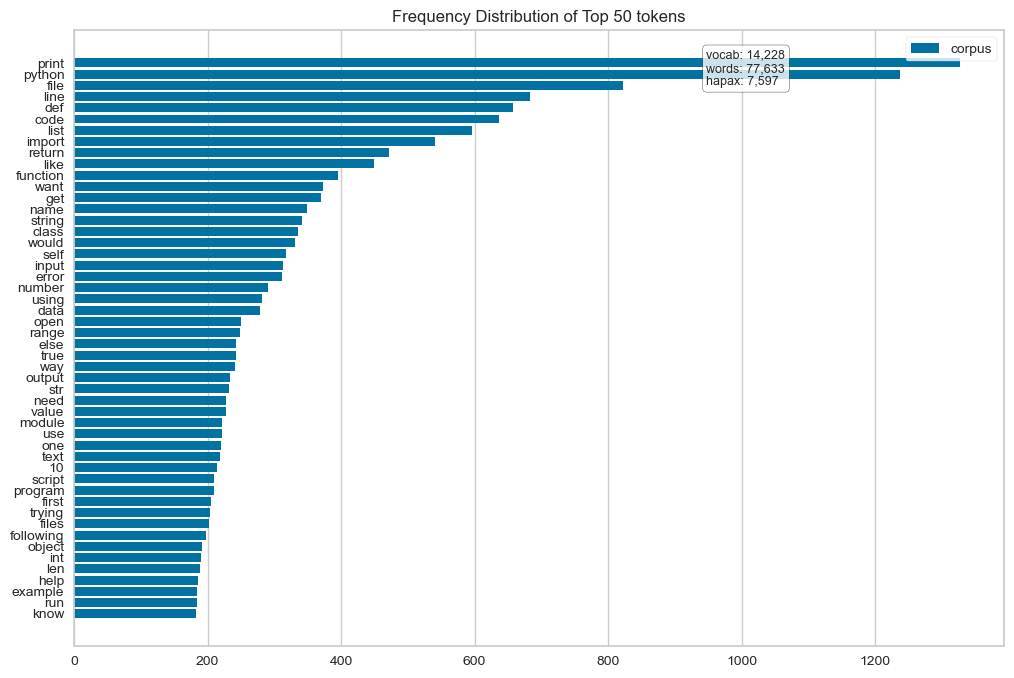

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [24]:
docs       = vectorizer.fit_transform(text for text in df.loc[df['tags'] == 'python']['post'])
features   = vectorizer.get_feature_names_out()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

We are done text preprocessing!

### Feature extractions
A core step for a typical NLP component is to convert raw text into features, which give a machine learning model a simpler, more focused view of the text

- We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1, 2, 3, ... 19

- stratify=y will make sure that after random split, the classes are still balanced, in our case

In [25]:
# LabelEncoder is a preprocessing technique in machine learning that is often used for encoding categorical labels 
# into numerical values
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.tags.values)
X_train, X_test, y_train, y_test = train_test_split(df.post.values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.1) 

### Tf-idf
term frequency–inverse document frequency

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

Basically, it is to scale down the impact of tokens that occur very frequently in every document, such as "a", "the"

TfidfVectorizer() Convert a collection of raw text or document to a matrix of Tf-idf features. And we will set important parameters

- strip_accents='unicode', replace all accented unicode char by their corresponding ASCII char
- analyzer='word', feature made of words
- token_pattern=r'\w{1,}', tokenize only words of 1+ chars
- ngram_range=(1, 3), features made of unigram, bigram, and trigram
- use_idf=True, Enable inverse-document-frequency reweighting
- smooth_idf=True, prevents zero division for unseen words
- sublinear_tf=True, Regularization technique that squishes the data to a lower, common magnitude -> 1 + log(tf)
- stop_words='english', Cleans the text for common, low-impact, filter words such as the, a, an, in ..etc, to make way for words that distinguish

In [27]:
tfidf = TfidfVectorizer(strip_accents='unicode', 
                        analyzer='word',
                        token_pattern=r'\w{1,}',
                        ngram_range=(1, 3), 
                        use_idf=True,
                        smooth_idf=True,
                        sublinear_tf=True,
                        stop_words = 'english')

# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

### Bag of Words
Count: Convert a collection of text documents to a matrix of token counts. Every sample text is represented as a vector indicating the count of a token in the text

Counting the occurrences of tokens in each document

When using Countvectorizer(), the tokens that occurs very frequently in every document are not penalized

- binary=True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts

In [28]:
# Using CountVectorizer to convert text data into a "bag of words" representation.
countvec = CountVectorizer(analyzer='word',
                           token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), 
                           stop_words = 'english', 
                           binary=True)

# Fit and transform CountVectorizer to both training and test sets
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

In [29]:
target_names = lbl_enc.classes_ 

### Fitting Logistic Regression on Tf-idf

In [30]:
'''
 Logistic Regression provides interpretable results. It gives you coefficients for each feature
 (in this case, words or TF-IDF values) that indicate the strength and direction of their influence on the classification. 
 This can be useful for understanding which words are important for making predictions
'''

#Initialize the Logistic Regression Classifier
logregclf = LogisticRegression()

#Fit the Classifier to the Training Data 
logregclf.fit(X_train_tfidf, y_train)
y_pred = logregclf.predict(X_test_tfidf)

#The trained classifier is used to predict labels for the test data, which has also been transformed into TF-IDF representations
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.7995
               precision    recall  f1-score   support

         .net       0.67      0.64      0.65       100
      android       0.98      0.85      0.91       103
    angularjs       0.99      0.88      0.93        98
      asp.net       0.76      0.85      0.80       101
            c       0.84      0.83      0.84        98
           c#       0.64      0.65      0.64        99
          c++       0.82      0.70      0.75       102
          css       0.83      0.86      0.85        96
         html       0.68      0.77      0.72       102
          ios       0.63      0.65      0.64       100
       iphone       0.71      0.68      0.70       101
         java       0.91      0.80      0.85       101
   javascript       0.81      0.82      0.81       101
       jquery       0.94      0.79      0.86       101
        mysql       0.84      0.86      0.85       100
  objective-c       0.68      0.74      0.71       101
          ph

### Fitting Logistic Regression on BOW

In [31]:
logregclf = LogisticRegression()
logregclf.fit(X_train_countvec, y_train)
y_pred = logregclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.815
               precision    recall  f1-score   support

         .net       0.66      0.68      0.67       100
      android       0.96      0.86      0.91       103
    angularjs       0.98      0.88      0.92        98
      asp.net       0.79      0.85      0.82       101
            c       0.84      0.85      0.84        98
           c#       0.62      0.67      0.64        99
          c++       0.82      0.70      0.75       102
          css       0.87      0.89      0.88        96
         html       0.72      0.79      0.75       102
          ios       0.70      0.64      0.67       100
       iphone       0.65      0.74      0.69       101
         java       0.89      0.84      0.86       101
   javascript       0.86      0.82      0.84       101
       jquery       0.90      0.84      0.87       101
        mysql       0.93      0.81      0.87       100
  objective-c       0.71      0.74      0.73       101
          php

### Fitting Naive Bayes on Tf-idf

In [32]:
'''
The code you've provided is for training a Multinomial Naive Bayes classifier (MultinomialNB) on TF-IDF transformed 
text data and evaluating its performance on the test set
'''

NBclf = MultinomialNB()
NBclf.fit(X_train_tfidf, y_train)
y_pred = NBclf.predict(X_test_tfidf)

#The trained Multinomial Naive Bayes classifier is used to predict labels for the test data, 
# which has also been transformed into TF-IDF representations (X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with NB: 0.7595
               precision    recall  f1-score   support

         .net       0.69      0.59      0.63       100
      android       0.89      0.84      0.87       103
    angularjs       0.94      0.92      0.93        98
      asp.net       0.70      0.78      0.74       101
            c       0.71      0.90      0.79        98
           c#       0.70      0.43      0.54        99
          c++       0.75      0.73      0.74       102
          css       0.75      0.83      0.79        96
         html       0.60      0.72      0.65       102
          ios       0.70      0.61      0.65       100
       iphone       0.75      0.66      0.71       101
         java       0.79      0.80      0.80       101
   javascript       0.90      0.72      0.80       101
       jquery       0.77      0.85      0.81       101
        mysql       0.62      0.92      0.74       100
  objective-c       0.71      0.71      0.71       101
          php   

### Fitting Naive Bayes on BOW

In [33]:
NBclf = MultinomialNB()
NBclf.fit(X_train_countvec, y_train)
y_pred = NBclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with NB: 0.7525
               precision    recall  f1-score   support

         .net       0.68      0.59      0.63       100
      android       0.90      0.82      0.86       103
    angularjs       0.86      0.95      0.90        98
      asp.net       0.70      0.77      0.73       101
            c       0.72      0.87      0.79        98
           c#       0.67      0.57      0.62        99
          c++       0.75      0.78      0.77       102
          css       0.76      0.84      0.80        96
         html       0.65      0.65      0.65       102
          ios       0.60      0.60      0.60       100
       iphone       0.74      0.48      0.58       101
         java       0.84      0.79      0.82       101
   javascript       0.84      0.75      0.80       101
       jquery       0.79      0.83      0.81       101
        mysql       0.64      0.92      0.76       100
  objective-c       0.68      0.68      0.68       101
          php   

### Fitting SVC (Support Vector Classifier) on Tf-idf
Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM

Also, note that before applying SVMs, we have to standardize the data

In [34]:
'''
The key steps in this code involve dimensionality reduction with Truncated SVD, standardization (scaling), 
and training a SVM classifier on the reduced and standardized data. This is a common approach for reducing the 
dimensionality of text data and applying machine learning algorithms while avoiding issues related to high-dimensional spaces
'''

#Truncated SVD is applied to reduce the dimensionality of the TF-IDF representations
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_tfidf)
X_train_svd = svd.transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.783
               precision    recall  f1-score   support

         .net       0.59      0.68      0.63       100
      android       0.96      0.83      0.89       103
    angularjs       0.98      0.86      0.91        98
      asp.net       0.81      0.74      0.77       101
            c       0.87      0.78      0.82        98
           c#       0.49      0.74      0.59        99
          c++       0.73      0.68      0.70       102
          css       0.87      0.85      0.86        96
         html       0.74      0.76      0.75       102
          ios       0.58      0.68      0.63       100
       iphone       0.66      0.60      0.63       101
         java       0.89      0.81      0.85       101
   javascript       0.82      0.79      0.80       101
       jquery       0.92      0.80      0.86       101
        mysql       0.95      0.79      0.86       100
  objective-c       0.77      0.65      0.71 

### Let's break down how to interpret these results:

- Accuracy: The accuracy of the model on the test set is 0.783, which means it correctly predicted the class labels for approximately 78.3% of the test samples. This is a measure of overall correctness

- Precision: Precision measures how many of the predicted positive instances were correctly classified. In your classification report, you have precision values for each class. For example, for the "android" class, the precision is 0.96, which means that 96% of the instances predicted as "android" were indeed "android" in reality. 
  Similarly, for other classes, you can interpret the precision values as the percentage of correct positive predictions.

- Recall: Recall measures how many of the actual positive instances were correctly classified. 
    For example, for the "android" class, the recall is 0.83, indicating that 83% of the actual "android" instances were correctly classified as "android." 
    You can interpret the recall values for other classes in the same way.

- F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. 
    A high F1-score indicates a good balance between precision and recall. For example, for the "android" class, the F1-score is 0.89, which is a good balance between precision and recall.

- Support: Support is the number of samples in each class in the test set. 
    It represents the actual distribution of classes in your test data

- Macro Avg: This is the average of precision, recall, and F1-score across all classes. In your case, it's an average across all programming language categories. 
    The macro average F1-score, for example, is 0.79

- Weighted Avg: This is the weighted average of precision, recall, and F1-score, considering the number of instances in each class. 
    It takes into account class imbalance. The weighted average F1-score, for example, is 0.79

### Fitting SVC (Support Vector Classifier) on BOW

In [35]:
'''
The code uses CountVectorizer instead of TF-IDF for feature extraction and applies Truncated SVD for dimensionality reduction. 
It then standardizes the data and uses a Support Vector Machine (SVM) classifier for text classification
'''

svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_countvec)
X_train_svd = svd.transform(X_train_countvec)
X_test_svd = svd.transform(X_test_countvec)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.7365
               precision    recall  f1-score   support

         .net       0.56      0.69      0.62       100
      android       0.93      0.75      0.83       103
    angularjs       0.94      0.80      0.86        98
      asp.net       0.70      0.72      0.71       101
            c       0.79      0.71      0.75        98
           c#       0.50      0.57      0.53        99
          c++       0.65      0.60      0.62       102
          css       0.88      0.84      0.86        96
         html       0.66      0.69      0.67       102
          ios       0.60      0.49      0.54       100
       iphone       0.45      0.65      0.53       101
         java       0.73      0.73      0.73       101
   javascript       0.80      0.75      0.78       101
       jquery       0.87      0.80      0.84       101
        mysql       0.89      0.85      0.87       100
  objective-c       0.60      0.57      0.59

### Fitting Random Forest on Tf-idf

In [36]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train_tfidf, y_train)
y_pred = RFclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with RF: 0.77
               precision    recall  f1-score   support

         .net       0.66      0.61      0.63       100
      android       0.97      0.83      0.90       103
    angularjs       0.99      0.89      0.94        98
      asp.net       0.78      0.80      0.79       101
            c       0.81      0.85      0.83        98
           c#       0.60      0.60      0.60        99
          c++       0.92      0.60      0.73       102
          css       0.57      0.89      0.70        96
         html       0.68      0.69      0.68       102
          ios       0.68      0.54      0.60       100
       iphone       0.58      0.66      0.62       101
         java       0.83      0.78      0.81       101
   javascript       0.79      0.76      0.77       101
       jquery       0.85      0.78      0.81       101
        mysql       0.85      0.82      0.83       100
  objective-c       0.70      0.75      0.72       101
          php     

### Fitting Random Forest on BOW

In [37]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train_countvec, y_train)
y_pred = RFclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with RF: 0.7635
               precision    recall  f1-score   support

         .net       0.67      0.60      0.63       100
      android       0.97      0.82      0.88       103
    angularjs       0.99      0.84      0.91        98
      asp.net       0.72      0.75      0.73       101
            c       0.75      0.85      0.79        98
           c#       0.66      0.64      0.65        99
          c++       0.85      0.59      0.69       102
          css       0.57      0.91      0.70        96
         html       0.60      0.72      0.65       102
          ios       0.73      0.46      0.56       100
       iphone       0.56      0.75      0.64       101
         java       0.86      0.80      0.83       101
   javascript       0.84      0.72      0.78       101
       jquery       0.92      0.77      0.84       101
        mysql       0.89      0.80      0.84       100
  objective-c       0.70      0.70      0.70       101
          php   

It seems Logistic Regerssion on BOW produced the best results, for this particular data set

### Improve the Model
- Gather more training data
- More text preprocessing, such as stemming and lemmatization
- Tune LogReg Hyperparameters, such as try different values of C with l1 and l2 penalty
- Try Xgboost. If things don’t go your way in predictive modeling, try Xgboost

### Fitting Xgboost on Tf-idf
We set n_jobs=-1 to use all of the CPU cores on our system, which is a good practice

In [38]:
Xgbclf = xgb.XGBClassifier(n_jobs=-1)
Xgbclf.fit(X_train_tfidf.tocsc(), y_train)
y_pred = Xgbclf.predict(X_test_tfidf.tocsc())
print("---Test Set Results---")
print("Accuracy with Xgboost: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with Xgboost: 0.8015
               precision    recall  f1-score   support

         .net       0.65      0.66      0.65       100
      android       0.97      0.87      0.92       103
    angularjs       0.98      0.89      0.93        98
      asp.net       0.77      0.82      0.79       101
            c       0.89      0.86      0.88        98
           c#       0.64      0.70      0.67        99
          c++       0.76      0.74      0.75       102
          css       0.81      0.83      0.82        96
         html       0.67      0.72      0.69       102
          ios       0.64      0.71      0.67       100
       iphone       0.65      0.72      0.68       101
         java       0.86      0.84      0.85       101
   javascript       0.85      0.83      0.84       101
       jquery       0.89      0.78      0.83       101
        mysql       0.86      0.85      0.85       100
  objective-c       0.73      0.68      0.71       101
          p

### Fitting Xgboost with BOW

In [ ]:
Xgbclf = xgb.XGBClassifier(n_jobs=-1)
Xgbclf.fit(X_train_countvec.tocsc(), y_train)
y_pred = Xgbclf.predict(X_test_countvec.tocsc())
print("---Test Set Results---")
print("Accuracy with Xgboost: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

### Misclassified:

In [40]:
for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
    if y != y_hat:
        print(f'post: {x} tag: {y} tag_pred: {y_hat}')

post: objc disable enable screen rotation work trying disable enable screen rotation viewcontrollers work get error use undeclared identifier shouldautorotatetointerfaceorientation using ios 8 miss bool shouldautorotatetointerfaceorientation uiinterfaceorientation interfaceorientation return interfaceorientation uiinterfaceorientationportrait tag: objective-c tag_pred: ios
post: oitcontrol zoom code controls new threeorbitcontrols camera controlsaddeventlistener change render live preview misc_control_orbit_demo see error console zoom someone show wrong thanks tag: javascript tag_pred: asp.net
post: tableview reloading data working uitableview deleting json data whenever deleting json data remove particular data tableview also whenever trying remove data first row throws exception like terminating app due uncaught exception nsinternalinconsistencyexception reason attempt delete row 1 section 0 contains 1 rows update app getting crashed anyone suggest problem following coding ibaction d

### Next Steps
- More text preprocessing, such as stemming and lemmatization
- Tune LogReg Hyperparameters, such as try different values of C with l1 and l2 penalty
- Try Doc2vec, which is sibling of Word2vec
- Try Xgboost. If things don’t go your way in predictive modeling, try Xgboost
- Gather more training data

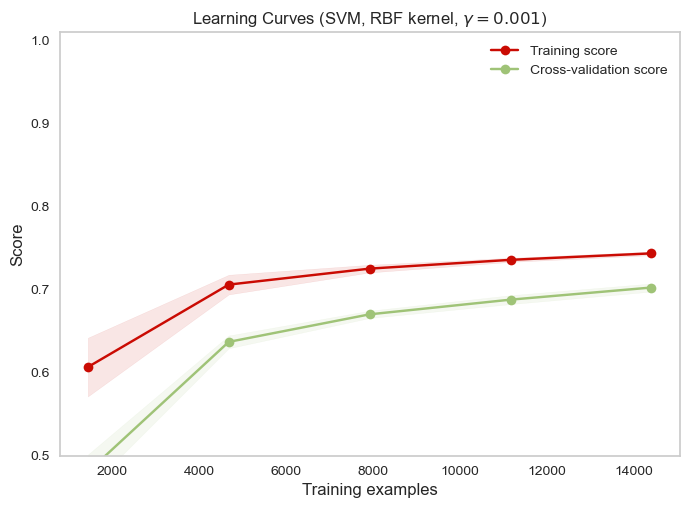

In [41]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
X, y = X_train_svd_scale, y_train
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=4)
plt.show();

Cross-validation score (green line) increases gradually

- able to learn from data
- Still low scores (high errors)
Should tweak model (perhaps increase model complexity), more feature engineering, more data